In [59]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec
pos_vectors = KeyedVectors.load_word2vec_format('../../kor2vec/pos_nouns.vec', binary=False)


In [60]:
import json
import numpy as np
from konlpy.tag import Kkma
from konlpy.utils import pprint
import math

l_quality= open("Lecture_quality.txt", "r", encoding="utf-8").readlines()
load= open("Load.txt", "r", encoding="utf-8").readlines()
grade= open("Grade.txt", "r", encoding="utf-8").readlines()
int_friendly= open("international_friendly.txt", "r", encoding="utf-8").readlines()
CATEGORY_COUNT = 3

In [61]:
scores = []
subjects = [l_quality, load, grade]
def add_to_dict(subject):
    subject_scores={}
    for i in range(len(subject)):
        p = subject[i].split("\t")
        subject_scores[p[0]] = float(p[1][:-1])
    scores.append(subject_scores)

for subject in subjects:
    add_to_dict(subject)

In [62]:
subject_mp = {"강의":0,"널널":1,"성적":2}
def calculate_score(s, subject_str):
    result = 0
    for k,v in scores[subject_mp[subject_str]].items():
        if k in s:
            result += v
#     result=1.0/(1+math.exp(-result))
    result=math.tanh(result)
    return result

In [63]:
REVIEWS = "cs_reviews"

f = open("../reviews_in_one_txt/" + REVIEWS + ".txt","r",encoding="utf-8").readlines()

scores_list = []
subjects_str = ["강의", "널널", "성적"]
for subject_str in subjects_str:
    scores_list_subject=[]
    for i in range(len(f[:])):
        line = f[i]
        course = json.loads(line)
        scores_list_subject.append(calculate_score(course["review_text"], subject_str))
    scores_list.append(scores_list_subject)


In [64]:
f_count_word = {}
count_word = {}
mp = {"A":5,"B":4,"C":3,"D":2,"F":1}

def calc_weight(s):
    return 3 - (mp[s])

for i in range(len(f)):
    line = f[i]
    course = json.loads(line)
    if course["강의"] == "?":
        continue
    words = course["review_text"].split()
    for w in words:
        if w not in count_word:
            count_word[w] = 0
        count_word[w] += calc_weight(course["강의"])


In [65]:
sorted_by_value = sorted(count_word.items(), key=lambda kv: kv[1])[::-1]

In [66]:
# sorted_by_value

In [67]:
score_sum=[0]*7
numberof = [0]*7

def calc_score_avg(column_name):
    for i in range(len(f[:])):
        course = json.loads(f[i])
        #print(mp[course["강의"]],(scores_list[i]))
        if course[column_name] == "?":
            continue
        score_sum[mp[course[column_name]]] += scores_list[subject_mp[column_name]][i]
        numberof[mp[course[column_name]]] += 1;
    

for x in subjects_str:
    print(x)
    score_sum=[0 for j in range(7)]
    numberof = [0 for j in range(7)]
    calc_score_avg(x)
    for k,v in mp.items():
        print(k,score_sum[v]/numberof[v])
    print("-----------------------")


강의
A 0.11654140171441107
B -0.11605949892652138
C -0.14389836361025826
D -0.3468267232471922
F -0.35336293460933754
-----------------------
널널
A 0.6492974124926542
B 0.5444906360106355
C 0.4577797871649972
D 0.27807863658615634
F -0.13546262635607484
-----------------------
성적
A 0.7766436165804492
B 0.7586327909212807
C 0.6174620042184407
D 0.30099574724343114
F -0.04403226531526962
-----------------------


In [68]:
def append_noun(s):
    return "('%s','Noun')" % (s)

naver_wv_categories = ["강의", "부담", "성적"]
wv_update = {}
for i in range(CATEGORY_COUNT):
    for k,v in scores[i].items():
        if append_noun(k) in pos_vectors.vocab:
#             print(k,naver_wv_categories[i])
#             print(pos_vectors.similarity(append_noun(k),append_noun(naver_wv_categories[i])))
            wv_update[k] = pos_vectors.similarity(append_noun(k),append_noun(naver_wv_categories[i]))
        

In [69]:
subjects_str

['강의', '널널', '성적']

In [70]:
review_update = {}
for i in range(len(f)):
    line = f[i]
    course = json.loads(line)

    for i in range(CATEGORY_COUNT):
        if course[subjects_str[i]] == "?":
            continue
        for k,v in scores[i].items():
             if k in course["review_text"]:
                if k not in review_update:
                    review_update[k] = 0
                review_update[k] += calc_weight(course[subjects_str[i]])*100.0/len(course["review_text"])


In [71]:
# review_update

In [ ]:
def calc_aggregated_score(s, subject_str):
    result = 0
    for k,v in aggregated_scores[subject_mp[subject_str]].items():
        if k in s:
            result += v
#     result=1.0/(1+math.exp(-result))
    result=math.tanh(result)
    return result

def calc_aggregated_score_sum(column_name):
    for i in range(len(f[:])):
        course = json.loads(f[i])
        if course[column_name] == "?":
            continue
        score_sum[mp[course[column_name]]] += calc_aggregated_score(course["review_text"], column_name)
        numberof[mp[course[column_name]]] += 1;

In [88]:
import matplotlib.pyplot as plt

ALPHA 0.0
강의


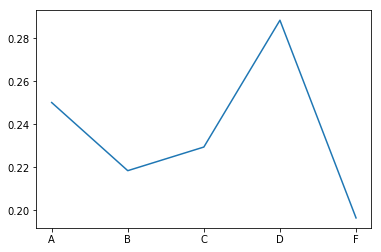

널널


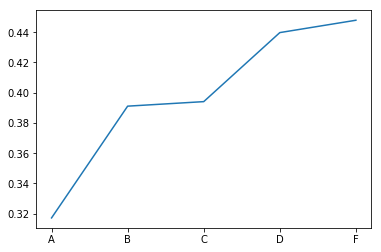

성적


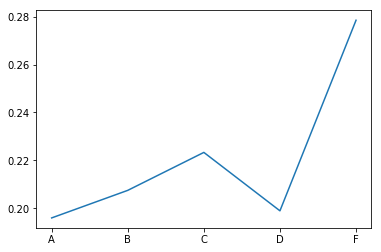

ALPHA 0.1
강의


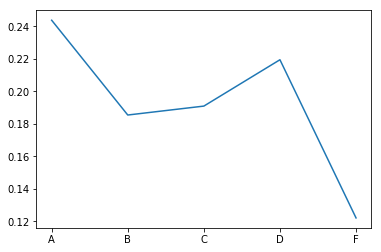

널널


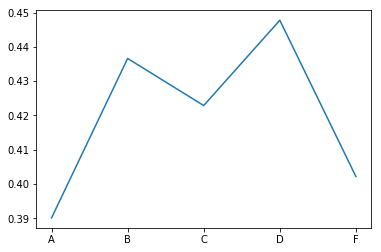

성적


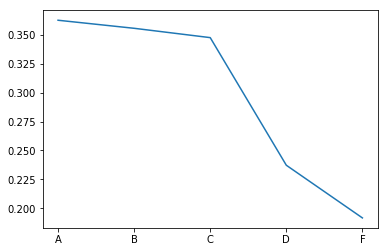

ALPHA 0.2
강의


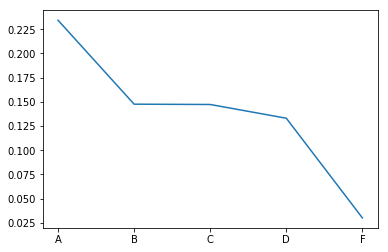

널널


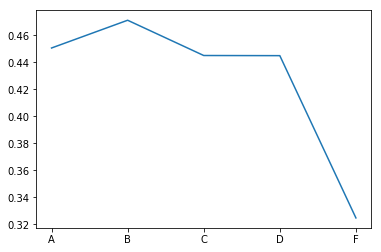

성적


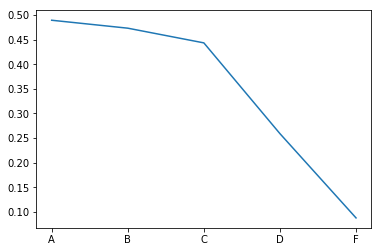

ALPHA 0.30000000000000004
강의


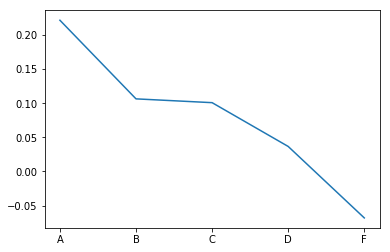

널널


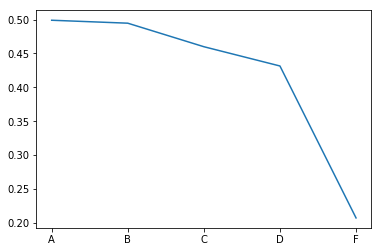

성적


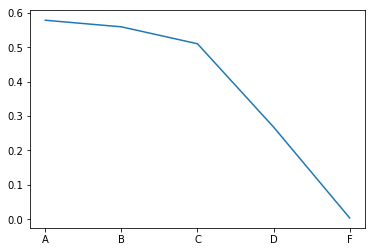

ALPHA 0.4
강의


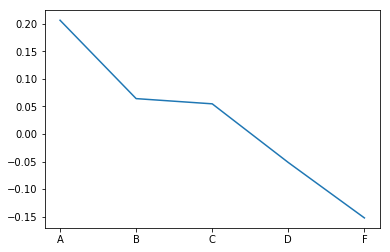

널널


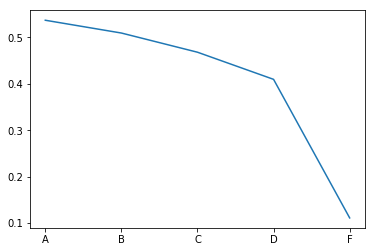

성적


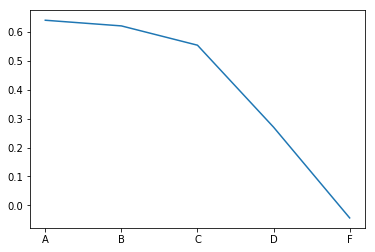

ALPHA 0.5
강의


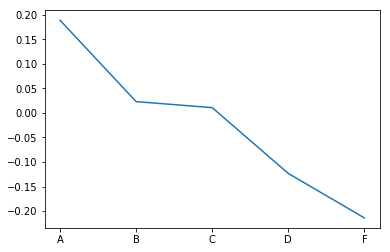

널널


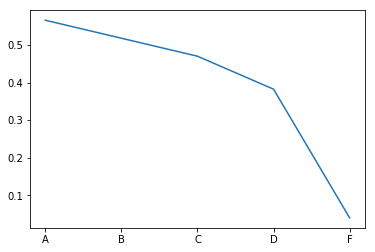

성적


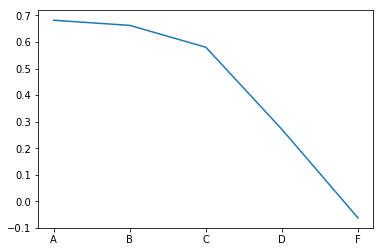

ALPHA 0.6000000000000001
강의


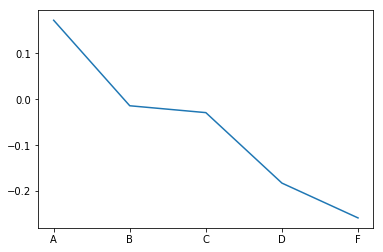

널널


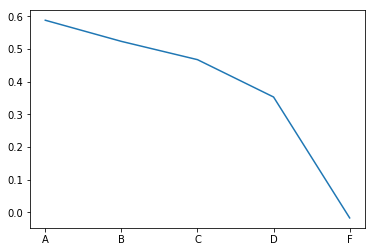

성적


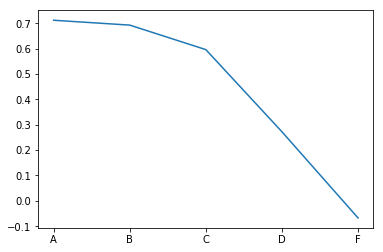

ALPHA 0.7000000000000001
강의


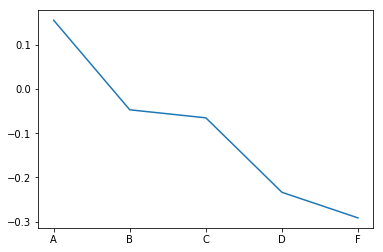

널널


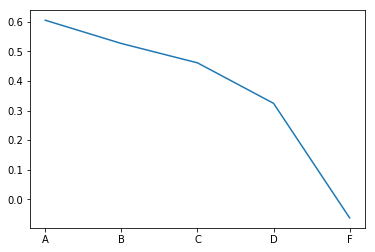

성적


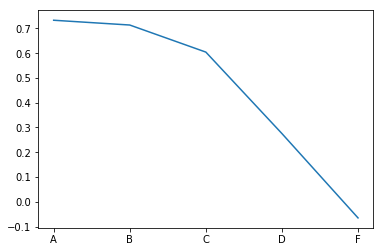

ALPHA 0.8
강의


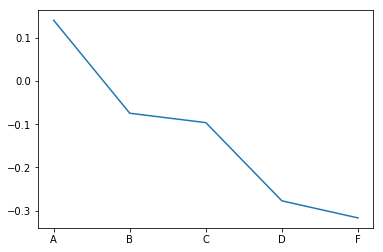

널널


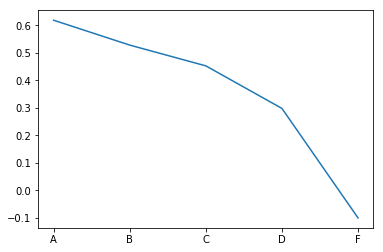

성적


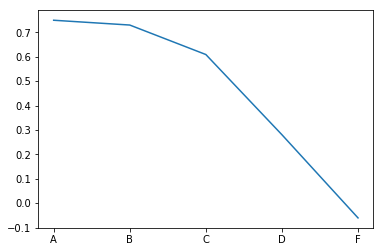

ALPHA 0.9
강의


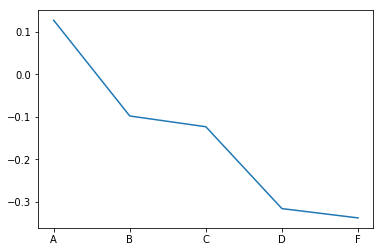

널널


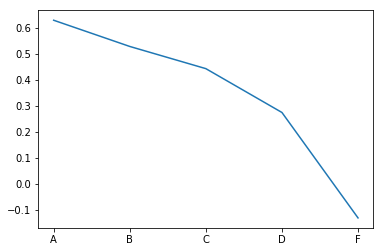

성적


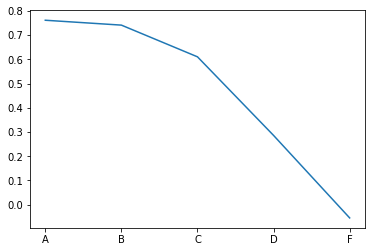

In [96]:
ALPHA = 0.9
BETA = 1e-4
GAMMA = 1 - ALPHA - BETA
for alpha in np.arange(0.0,1.1,0.1):
    for beta in np.arange(0.0, 1.1 - alpha, 0.1):
        print("A",alpha,"Beta:")
        
        ALPHA = alpha
        BETA = beta
        GAMMA = 1 - ALPHA - BETA
        if GAMMA < 0 :
            continue
        aggregated_scores = [{} for i in range(CATEGORY_COUNT)]
        for i in range(CATEGORY_COUNT):
            for k,v in scores[i].items():
                aggregated_scores[i][k] = v*ALPHA
                if k in review_update:
                    aggregated_scores[i][k] += review_update[k]*BETA

                if k in wv_update:
                    aggregated_scores[i][k] += wv_update[k]*GAMMA

        for x in subjects_str:
            print(x)
            score_sum=[0 for j in range(7)]
            numberof = [0 for j in range(7)]
            calc_aggregated_score_sum(x)
            x_plt_list = []
            y_plt_list = []

            for k,v in mp.items():
    #             print(k,score_sum[v]/numberof[v])
                x_plt_list.append(score_sum[v]/numberof[v])
                y_plt_list.append(k)

            plt.plot(y_plt_list,x_plt_list)
            plt.show()
    #         break

    #         print("-----------------------")            

In [83]:
# for i in range(CATEGORY_COUNT):
#     with open(str(i) + "_updated.txt","w",encoding="utf-8") as out:
#         for k,v in aggregated_scores[i].items():
#             out.write(k+"\t" + str(v) + "\n")

In [84]:
for x in subjects_str:
    print(x)
    score_sum=[0 for j in range(7)]
    numberof = [0 for j in range(7)]
    calc_aggregated_score_sum(x)
    for k,v in mp.items():
        print(k,score_sum[v]/numberof[v])
    print("-----------------------")

강의
A 0.12697088382937285
B -0.09796008929554788
C -0.12325163935977054
D -0.3155726649297984
F -0.3374563490141961
-----------------------
널널
A 0.6286555379900564
B 0.5278763326256604
C 0.44254807400036306
D 0.2739666531162874
F -0.1314813863669856
-----------------------
성적
A 0.7615698288138885
B 0.7414356576621278
C 0.6105049707193498
D 0.28598733411107097
F -0.05470529650585389
-----------------------
